# Time travel

## Review

We introduced that LangGraph offers several ways to get or update agent state systematically to support various human-in-the-loop workflows:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints support approval.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing and re-playing from past states.

--- 

TO DO: 
 
* This is pretty confusing concept in general... id really try to explain this as clearly as possible.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

Let's build out agent.

In [1]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

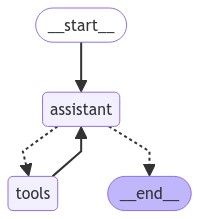

In [2]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [3]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oZMIYusXtwqy3lRQPYoB8S42)
 Call ID: call_oZMIYusXtwqy3lRQPYoB8S42
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

Let's browse the state history of our agent.

We can simply use `get_state_history` and pass our `thread`.

In [4]:
all_states = []
for state in graph.get_state_history(thread):
    print(state)
    all_states.append(state)
    print("--")

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='74c83b6a-0751-435d-8d43-30580d111161'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oZMIYusXtwqy3lRQPYoB8S42', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 133, 'total_tokens': 150}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06aa66a2-75da-4db3-b924-1da2d095797c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_oZMIYusXtwqy3lRQPYoB8S42', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 17, 'total_tokens': 150}), ToolMessage(content='6', name='multiply', id='0cffa5fd-2a42-4340-9dc3-61f0aab83cae', tool_call_id='call_oZMIYusXtwqy3lRQPYoB8S42'), AIMessage(content='The result of multiplying 2 and 3 is 6.', response_metadata={'token

## Replaying 

We can restart our agent from any of these states.

In [5]:
for m in all_states[0].values['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oZMIYusXtwqy3lRQPYoB8S42)
 Call ID: call_oZMIYusXtwqy3lRQPYoB8S42
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Let's look back at the state update containing only the human message.

In [6]:
for m in all_states[3].values['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [7]:
to_replay = all_states[3]
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', id='74c83b6a-0751-435d-8d43-30580d111161')]}

We can see the next node to call.

In [11]:
to_replay.next

('assistant',)

In [12]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef60d7c-a058-6554-8000-b02d7c3f7efe'}}

To replay from here, we simply pass the config back to the agent!

It just resumes from right where it left off, with the assistant.

In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_oZMIYusXtwqy3lRQPYoB8S42)
 Call ID: call_oZMIYusXtwqy3lRQPYoB8S42
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Forking

We can fork from a prior state to let the agent explore alternate trajectories.

In [19]:
to_replay = all_states[2]
to_replay.values["messages"]

[HumanMessage(content='Multiply 2 and 3', id='74c83b6a-0751-435d-8d43-30580d111161'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oZMIYusXtwqy3lRQPYoB8S42', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 133, 'total_tokens': 150}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06aa66a2-75da-4db3-b924-1da2d095797c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_oZMIYusXtwqy3lRQPYoB8S42', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 17, 'total_tokens': 150})]

Let's modify the tool call.

In [21]:
to_replay.values["messages"][-1].tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_oZMIYusXtwqy3lRQPYoB8S42',
  'type': 'tool_call'}]

In [22]:
tool_call = to_replay.values["messages"][-1]
tool_call.tool_calls[0]

{'name': 'multiply',
 'args': {'a': 2, 'b': 3},
 'id': 'call_oZMIYusXtwqy3lRQPYoB8S42',
 'type': 'tool_call'}

In [26]:
tool_call.tool_calls[0]["args"] = {'a': 5, 'b': 3}
tool_call.tool_calls[0]

{'name': 'multiply',
 'args': {'a': 5, 'b': 3},
 'id': 'call_oZMIYusXtwqy3lRQPYoB8S42',
 'type': 'tool_call'}

We've updated the tool call, and now we can update the state. 

In [27]:
branch_config = graph.update_state(
    to_replay.config,
    {"messages": [tool_call]},
)

And, we invoke we our updated tool call!

In [28]:
for event in graph.stream(None, branch_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.
